In [1]:
import os
import re
import pandas as pd
from PIL import Image, ImageOps, ImageEnhance
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np

In [2]:
def get_gif_dataframe(gif_dir):
    data = []
    for label in os.listdir(gif_dir):
        label_dir = os.path.join(gif_dir, label)
        if os.path.isdir(label_dir):
            for gif_file in os.listdir(label_dir):
                if gif_file.endswith('.gif'):
                    gif_path = os.path.join(label_dir, gif_file)
                    data.append({'Subfolder': gif_path, 'Label': label})
    return pd.DataFrame(data)

original_gif_dir = '/Users/sallu/Desktop/original_gifs'
generated_gif_dir = '/Users/sallu/Desktop/generated_gifs'

original_gif_df = get_gif_dataframe(original_gif_dir)
generated_gif_df = get_gif_dataframe(generated_gif_dir)

original_gif_df['Source'] = 'Original'
generated_gif_df['Source'] = 'Generated'

combined_gif_df = pd.concat([original_gif_df, generated_gif_df], ignore_index=True)

In [3]:
pd.set_option('display.max_colwidth', None)
combined_gif_df

Subfolder  \
0    /Users/sallu/Desktop/original_gifs/10_days_high_infestation/CRI_D10_500_6_23317_01.gif   
1    /Users/sallu/Desktop/original_gifs/10_days_high_infestation/CRI_D10_500_3_23314_01.gif   
2    /Users/sallu/Desktop/original_gifs/10_days_high_infestation/CRI_D10_500_5_23316_01.gif   
3    /Users/sallu/Desktop/original_gifs/10_days_high_infestation/CRI_D10_500-4_23141_01.gif   
4    /Users/sallu/Desktop/original_gifs/10_days_high_infestation/CRI_D10_500_2_23313_01.gif   
..                                                                                      ...   
834               /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_10.gif   
835               /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_48.gif   
836                /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_8.gif   
837                /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_9.gif   
838               /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_49.gif   

                        Label     Source  
0    10_days_high_infestation   Original  
1    10_days_high_infestation   Original  
2    10_days_high_infestation   Original  
3    10_days_high_infestation   Original  
4    10_days_high_infestation   Original  
..                        ...        ...  
834   4_days_high_infestation  Generated  
835   4_days_high_infestation  Generated  
836   4_days_high_infestation  Generated  
837   4_days_high_infestation  Generated  
838   4_days_high_infestation  Generated  

[839 rows x 3 columns]

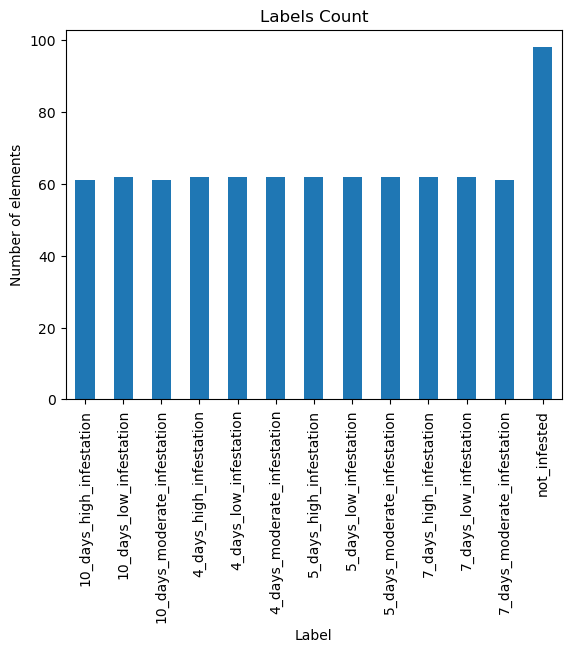

In [4]:
def count_labels(df):
    label_counts = df.groupby('Label').size()
    label_counts.plot(kind='bar')
    plt.xlabel('Label')
    plt.ylabel('Number of elements')
    plt.title('Labels Count')
    plt.show()

count_labels(combined_gif_df)

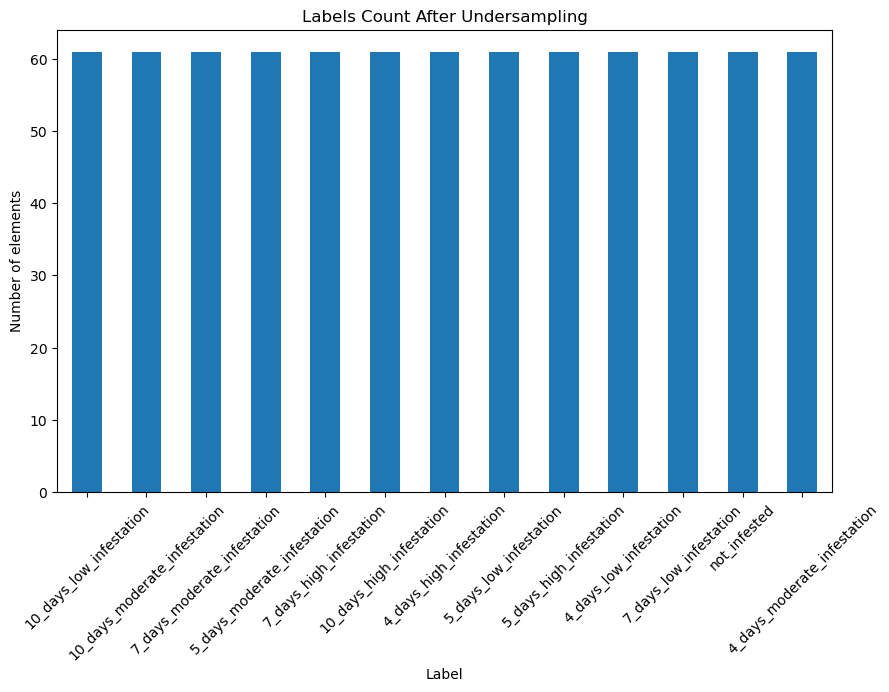

In [5]:
majority_class = 'not_infested'
minority_classes = original_gif_df['Label'].unique().tolist()
minority_classes.remove(majority_class)

majority_data = combined_gif_df[combined_gif_df['Label'] == majority_class]
minority_data = combined_gif_df[combined_gif_df['Label'] != majority_class]

minority_class_counts = minority_data['Label'].value_counts()
min_count = minority_class_counts.min()

majority_data_undersampled = majority_data.sample(n=min_count, random_state=42)

minority_data_undersampled = minority_data.groupby('Label').sample(n=min_count, random_state=42)

undersampled_data = pd.concat([majority_data_undersampled, minority_data_undersampled], axis=0)

undersampled_data = undersampled_data.sample(frac=1, random_state=42).reset_index(drop=True)


plt.figure(figsize=(10, 6))
undersampled_data['Label'].value_counts().plot(kind='bar')
plt.title('Labels Count After Undersampling')
plt.xlabel('Label')
plt.ylabel('Number of elements')
plt.xticks(rotation=45)
plt.show()

In [6]:
combined_gif_df=undersampled_data

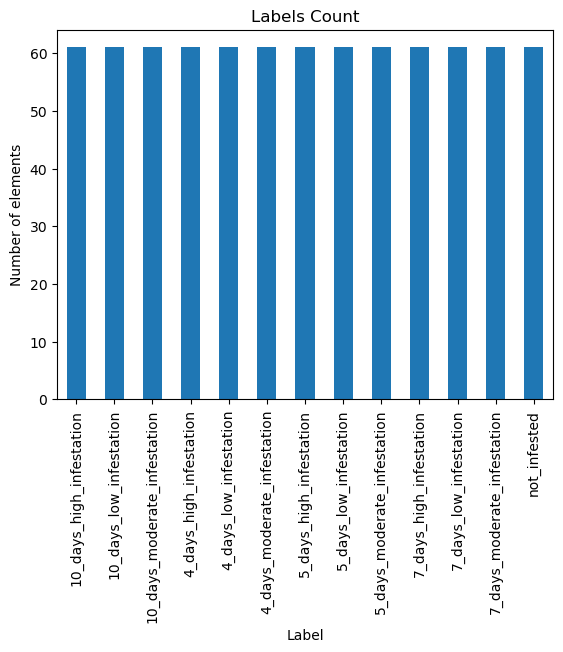

In [7]:
count_labels(combined_gif_df)

In [8]:
pd.set_option('display.max_colwidth', None)
combined_gif_df

Subfolder  \
0               /Users/sallu/Desktop/generated_gifs/10_days_low_infestation/limone_33.gif   
1          /Users/sallu/Desktop/generated_gifs/10_days_moderate_infestation/limone_12.gif   
2           /Users/sallu/Desktop/generated_gifs/7_days_moderate_infestation/limone_28.gif   
3           /Users/sallu/Desktop/generated_gifs/5_days_moderate_infestation/limone_30.gif   
4               /Users/sallu/Desktop/generated_gifs/7_days_high_infestation/limone_45.gif   
..                                                                                    ...   
788            /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_23.gif   
789            /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_29.gif   
790              /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_4.gif   
791  /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_5_23364_01.gif   
792            /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_28.gif   

                            Label     Source  
0         10_days_low_infestation  Generated  
1    10_days_moderate_infestation  Generated  
2     7_days_moderate_infestation  Generated  
3     5_days_moderate_infestation  Generated  
4         7_days_high_infestation  Generated  
..                            ...        ...  
788      10_days_high_infestation  Generated  
789      10_days_high_infestation  Generated  
790       4_days_high_infestation  Generated  
791       5_days_high_infestation   Original  
792      10_days_high_infestation  Generated  

[793 rows x 3 columns]

In [9]:
combined_gif_df['video_name'] = combined_gif_df['Subfolder']
combined_gif_df['tag'] = combined_gif_df['Label'].astype(str)

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    combined_gif_df, 
    test_size=0.3,  
    random_state=42  
)

In [11]:
test_df[['Label']].value_counts()

Label                       
4_days_moderate_infestation     23
7_days_moderate_infestation     23
10_days_moderate_infestation    21
7_days_low_infestation          21
not_infested                    20
10_days_low_infestation         18
5_days_moderate_infestation     18
10_days_high_infestation        16
4_days_high_infestation         16
4_days_low_infestation          16
5_days_high_infestation         16
5_days_low_infestation          15
7_days_high_infestation         15
Name: count, dtype: int64

In [12]:
test_df

Subfolder  \
137        /Users/sallu/Desktop/original_gifs/7_days_high_infestation/CRI_D7_500_5_23166_01.gif   
198                   /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_2.gif   
739               /Users/sallu/Desktop/generated_gifs/5_days_moderate_infestation/limone_48.gif   
583                    /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_29.gif   
655  /Users/sallu/Desktop/original_gifs/10_days_moderate_infestation/CRI_D10_100_1_23306_01.gif   
..                                                                                          ...   
132                    /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_16.gif   
368               /Users/sallu/Desktop/generated_gifs/7_days_moderate_infestation/limone_29.gif   
625                   /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_34.gif   
462                   /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_49.gif   
742                    /Users/sallu/Desktop/generated_gifs/10_days_low_infestation/limone_7.gif   

                            Label     Source  \
137       7_days_high_infestation   Original   
198      10_days_high_infestation  Generated   
739   5_days_moderate_infestation  Generated   
583        7_days_low_infestation  Generated   
655  10_days_moderate_infestation   Original   
..                            ...        ...   
132        7_days_low_infestation  Generated   
368   7_days_moderate_infestation  Generated   
625       4_days_high_infestation  Generated   
462       5_days_high_infestation  Generated   
742       10_days_low_infestation  Generated   

                                                                                     video_name  \
137        /Users/sallu/Desktop/original_gifs/7_days_high_infestation/CRI_D7_500_5_23166_01.gif   
198                   /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_2.gif   
739               /Users/sallu/Desktop/generated_gifs/5_days_moderate_infestation/limone_48.gif   
583                    /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_29.gif   
655  /Users/sallu/Desktop/original_gifs/10_days_moderate_infestation/CRI_D10_100_1_23306_01.gif   
..                                                                                          ...   
132                    /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_16.gif   
368               /Users/sallu/Desktop/generated_gifs/7_days_moderate_infestation/limone_29.gif   
625                   /Users/sallu/Desktop/generated_gifs/4_days_high_infestation/limone_34.gif   
462                   /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_49.gif   
742                    /Users/sallu/Desktop/generated_gifs/10_days_low_infestation/limone_7.gif   

                              tag  
137       7_days_high_infestation  
198      10_days_high_infestation  
739   5_days_moderate_infestation  
583        7_days_low_infestation  
655  10_days_moderate_infestation  
..                            ...  
132        7_days_low_infestation  
368   7_days_moderate_infestation  
625       4_days_high_infestation  
462       5_days_high_infestation  
742       10_days_low_infestation  

[238 rows x 5 columns]

In [13]:
train_df

Subfolder  \
547         /Users/sallu/Desktop/generated_gifs/4_days_moderate_infestation/limone_39.gif   
41   /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01.gif   
572              /Users/sallu/Desktop/generated_gifs/5_days_low_infestation/limone_21.gif   
108              /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_25.gif   
338             /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_43.gif   
..                                                                                    ...   
71                         /Users/sallu/Desktop/generated_gifs/not_infested/limone_12.gif   
106        /Users/sallu/Desktop/generated_gifs/10_days_moderate_infestation/limone_26.gif   
270  /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_2_23187_01.gif   
435  /Users/sallu/Desktop/original_gifs/10_days_low_infestation/CRI_D10_50-2_23151_01.gif   
102             /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_0.gif   

                            Label     Source  \
547   4_days_moderate_infestation  Generated   
41        5_days_high_infestation   Original   
572        5_days_low_infestation  Generated   
108        7_days_low_infestation  Generated   
338       5_days_high_infestation  Generated   
..                            ...        ...   
71                   not_infested  Generated   
106  10_days_moderate_infestation  Generated   
270       5_days_high_infestation   Original   
435       10_days_low_infestation   Original   
102      10_days_high_infestation  Generated   

                                                                               video_name  \
547         /Users/sallu/Desktop/generated_gifs/4_days_moderate_infestation/limone_39.gif   
41   /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01.gif   
572              /Users/sallu/Desktop/generated_gifs/5_days_low_infestation/limone_21.gif   
108              /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_25.gif   
338             /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_43.gif   
..                                                                                    ...   
71                         /Users/sallu/Desktop/generated_gifs/not_infested/limone_12.gif   
106        /Users/sallu/Desktop/generated_gifs/10_days_moderate_infestation/limone_26.gif   
270  /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_2_23187_01.gif   
435  /Users/sallu/Desktop/original_gifs/10_days_low_infestation/CRI_D10_50-2_23151_01.gif   
102             /Users/sallu/Desktop/generated_gifs/10_days_high_infestation/limone_0.gif   

                              tag  
547   4_days_moderate_infestation  
41        5_days_high_infestation  
572        5_days_low_infestation  
108        7_days_low_infestation  
338       5_days_high_infestation  
..                            ...  
71                   not_infested  
106  10_days_moderate_infestation  
270       5_days_high_infestation  
435       10_days_low_infestation  
102      10_days_high_infestation  

[555 rows x 5 columns]

In [15]:
import pandas as pd
import os
from PIL import Image, ImageSequence
import numpy as np
import imgaug.augmenters as iaa

original_gifs = train_df[(train_df['Source'] == 'Original') | (train_df['Source'] == 'Generated')]

seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.AddToHueAndSaturation((-20, 20)),
    iaa.LinearContrast((0.75, 1.5))
])

augmented_data = []

def augment_gif(input_path, output_dir, label, num_variants=5):
    img = Image.open(input_path)
    frames = [frame.copy() for frame in ImageSequence.Iterator(img)]
    
    for i in range(num_variants):
        augmented_frames = []
        
        for frame in frames:
            if frame.mode != 'RGB':
                frame = frame.convert('RGB')
            frame_array = np.array(frame)
            augmented_frame_array = seq(image=frame_array)
            augmented_frame = Image.fromarray(augmented_frame_array)
            augmented_frames.append(augmented_frame)
        
        base_name, ext = os.path.splitext(os.path.basename(input_path))
        variant_output_name = f"{base_name}_aug_{i+1}{ext}"
        output_path = os.path.join(output_dir, variant_output_name)
        
        augmented_frames[0].save(output_path, save_all=True, append_images=augmented_frames[1:], loop=0)
        print(f"Augmented GIF saved to: {output_path}")
        
        augmented_data.append({
            'Subfolder': output_path,
            'Label': label,
            'Source': 'Augmented'
        })

augmented_gifs_base_dir = '/Users/sallu/Desktop/augmented_train_gifs'
os.makedirs(augmented_gifs_base_dir, exist_ok=True)

for index, row in original_gifs.iterrows():
    input_path = row['Subfolder']
    label = row['Label']
    output_dir = os.path.join(augmented_gifs_base_dir, label)
    os.makedirs(output_dir, exist_ok=True)
    
    augment_gif(input_path, output_dir, label, num_variants=5)

augmented_df = pd.DataFrame(augmented_data)


Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/4_days_moderate_infestation/limone_39_aug_1.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/4_days_moderate_infestation/limone_39_aug_2.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/4_days_moderate_infestation/limone_39_aug_3.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/4_days_moderate_infestation/limone_39_aug_4.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/4_days_moderate_infestation/limone_39_aug_5.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01_aug_1.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01_aug_2.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01_aug_3.gif
Augmented GIF saved to: /Users/sallu/Desktop/augmented_train_gif

In [16]:
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

In [17]:
train_df

Subfolder  \
0             /Users/sallu/Desktop/generated_gifs/4_days_moderate_infestation/limone_39.gif   
1      /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01.gif   
2                  /Users/sallu/Desktop/generated_gifs/5_days_low_infestation/limone_21.gif   
3                  /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_25.gif   
4                 /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_43.gif   
...                                                                                     ...   
3325  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_1.gif   
3326  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_2.gif   
3327  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_3.gif   
3328  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_4.gif   
3329  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_5.gif   

                            Label     Source  \
0     4_days_moderate_infestation  Generated   
1         5_days_high_infestation   Original   
2          5_days_low_infestation  Generated   
3          7_days_low_infestation  Generated   
4         5_days_high_infestation  Generated   
...                           ...        ...   
3325     10_days_high_infestation  Augmented   
3326     10_days_high_infestation  Augmented   
3327     10_days_high_infestation  Augmented   
3328     10_days_high_infestation  Augmented   
3329     10_days_high_infestation  Augmented   

                                                                                video_name  \
0            /Users/sallu/Desktop/generated_gifs/4_days_moderate_infestation/limone_39.gif   
1     /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01.gif   
2                 /Users/sallu/Desktop/generated_gifs/5_days_low_infestation/limone_21.gif   
3                 /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_25.gif   
4                /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_43.gif   
...                                                                                    ...   
3325                                                                                   NaN   
3326                                                                                   NaN   
3327                                                                                   NaN   
3328                                                                                   NaN   
3329                                                                                   NaN   

                              tag  
0     4_days_moderate_infestation  
1         5_days_high_infestation  
2          5_days_low_infestation  
3          7_days_low_infestation  
4         5_days_high_infestation  
...                           ...  
3325                          NaN  
3326                          NaN  
3327                          NaN  
3328                          NaN  
3329                          NaN  

[3330 rows x 5 columns]

In [18]:
train_df['video_name'] = train_df['Subfolder']
train_df['tag'] = train_df['Label'].astype(str)

In [19]:
train_df

Subfolder  \
0             /Users/sallu/Desktop/generated_gifs/4_days_moderate_infestation/limone_39.gif   
1      /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01.gif   
2                  /Users/sallu/Desktop/generated_gifs/5_days_low_infestation/limone_21.gif   
3                  /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_25.gif   
4                 /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_43.gif   
...                                                                                     ...   
3325  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_1.gif   
3326  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_2.gif   
3327  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_3.gif   
3328  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_4.gif   
3329  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_5.gif   

                            Label     Source  \
0     4_days_moderate_infestation  Generated   
1         5_days_high_infestation   Original   
2          5_days_low_infestation  Generated   
3          7_days_low_infestation  Generated   
4         5_days_high_infestation  Generated   
...                           ...        ...   
3325     10_days_high_infestation  Augmented   
3326     10_days_high_infestation  Augmented   
3327     10_days_high_infestation  Augmented   
3328     10_days_high_infestation  Augmented   
3329     10_days_high_infestation  Augmented   

                                                                                 video_name  \
0             /Users/sallu/Desktop/generated_gifs/4_days_moderate_infestation/limone_39.gif   
1      /Users/sallu/Desktop/original_gifs/5_days_high_infestation/CRI_D5_500_1_23186_01.gif   
2                  /Users/sallu/Desktop/generated_gifs/5_days_low_infestation/limone_21.gif   
3                  /Users/sallu/Desktop/generated_gifs/7_days_low_infestation/limone_25.gif   
4                 /Users/sallu/Desktop/generated_gifs/5_days_high_infestation/limone_43.gif   
...                                                                                     ...   
3325  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_1.gif   
3326  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_2.gif   
3327  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_3.gif   
3328  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_4.gif   
3329  /Users/sallu/Desktop/augmented_train_gifs/10_days_high_infestation/limone_0_aug_5.gif   

                              tag  
0     4_days_moderate_infestation  
1         5_days_high_infestation  
2          5_days_low_infestation  
3          7_days_low_infestation  
4         5_days_high_infestation  
...                           ...  
3325     10_days_high_infestation  
3326     10_days_high_infestation  
3327     10_days_high_infestation  
3328     10_days_high_infestation  
3329     10_days_high_infestation  

[3330 rows x 5 columns]

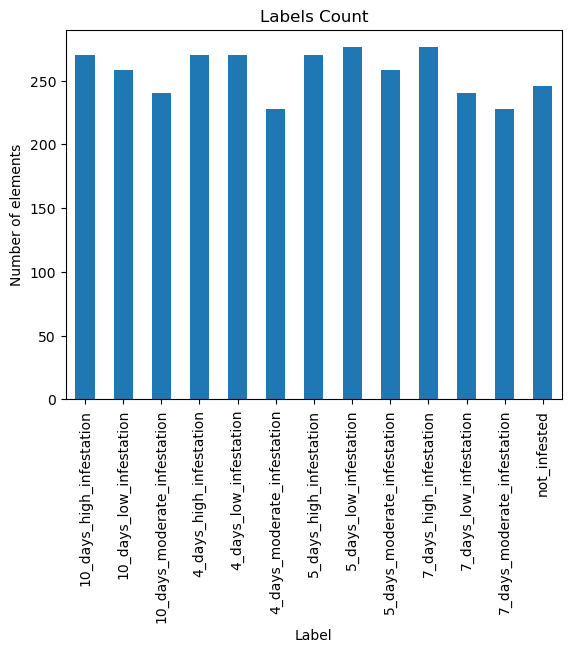

In [20]:
count_labels(train_df)

In [36]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 96


EPOCHS = 30

In [22]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

#from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

In [23]:
def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
            if frame.shape[:2] != (IMG_SIZE, IMG_SIZE):
                frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))  # Resize frame
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)

# Build feature extractor
def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

# Label preprocessing with StringLookup
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())

# Prepare all videos function
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate((frames, padding))

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )
                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

2024-09-07 10:05:07.823254: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-07 10:05:07.823423: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-07 10:05:07.823430: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-07 10:05:07.824343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-07 10:05:07.824878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['10_days_high_infestation', '10_days_low_infestation', '10_days_moderate_infestation', '4_days_high_infestation', '4_days_low_infestation', '4_days_moderate_infestation', '5_days_high_infestation', '5_days_low_infestation', '5_days_moderate_infestation', '7_days_high_infestation', '7_days_low_infestation', '7_days_moderate_infestation', 'not_infested']


In [24]:
train_data, train_labels = prepare_all_videos(train_df, "")
test_data, test_labels = prepare_all_videos(test_df, "")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

2024-09-07 10:05:12.355526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 72ms/step
Frame features in train set: (20, 1024)
Frame masks in train set: (20, 1024)


In [25]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = tf.cast(inputs, self.compute_dtype)
        length = tf.shape(inputs)[1]
        positions = tf.keras.backend.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

In [26]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [34]:
import keras
from sklearn.metrics import f1_score
import numpy as np

def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],  
    )
    return model

def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])

    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.10,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)

    _, accuracy = model.evaluate(test_data, test_labels)
    
    test_predictions = np.argmax(model.predict(test_data), axis=1)

    test_weighted_f1 = f1_score(test_labels, test_predictions, average='weighted')

    print(f"Test Accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Weighted F1 Score: {round(test_weighted_f1, 4)}")

    return model

In [37]:
trained_model = run_experiment()

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 3.5309 - accuracy: 0.1338
Epoch 1: val_loss improved from inf to 2.30829, saving model to /tmp/video_classifier.weights.h5
94/94 [==============================] - 14s 139ms/step - loss: 3.5309 - accuracy: 0.1338 - val_loss: 2.3083 - val_accuracy: 0.2012
Epoch 2/30
94/94 [==============================] - ETA: 0s - loss: 1.8770 - accuracy: 0.4067
Epoch 2: val_loss improved from 2.30829 to 1.55711, saving model to /tmp/video_classifier.weights.h5
94/94 [==============================] - 15s 163ms/step - loss: 1.8770 - accuracy: 0.4067 - val_loss: 1.5571 - val_accuracy: 0.5255
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 1.2602 - accuracy: 0.6019
Epoch 3: val_loss improved from 1.55711 to 1.26816, saving model to /tmp/video_classifier.weights.h5
94/94 [==============================] - 16s 170ms/step - loss: 1.2602 - accuracy: 0.6019 - val_loss: 1.2682 - val_accuracy: 0.6396
Epoch 4/30
94/94 [=====

1/1 [==============================] - 0s 37ms/step
  7_days_moderate_infestation: 100.00%
  5_days_high_infestation:  0.00%
  not_infested:  0.00%
  4_days_high_infestation:  0.00%
  4_days_moderate_infestation:  0.00%
  4_days_low_infestation:  0.00%
  10_days_moderate_infestation:  0.00%
  10_days_high_infestation:  0.00%
  10_days_low_infestation:  0.00%
  5_days_moderate_infestation:  0.00%
  5_days_low_infestation:  0.00%
  7_days_high_infestation:  0.00%
  7_days_low_infestation:  0.00%


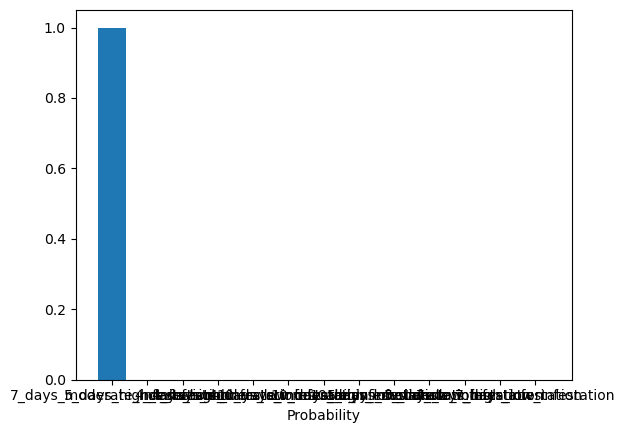

Test video path: /Users/sallu/Desktop/generated_gifs/7_days_moderate_infestation/limone_32.gif


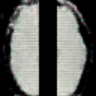

In [39]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), offload_to_cpu=True)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
import imageio
import numpy as np
from IPython.display import display, Image

def to_gif(images, filename="animation.gif", fps=10):
    # Ensure images are of type uint8
    converted_images = images.astype(np.uint8)
    # Save the images as a GIF
    imageio.mimsave(filename, converted_images, fps=fps)
    # Display the GIF
    with open(filename, "rb") as file:
        display(Image(data=file.read(), format="png"))


test_video = np.random.choice(test_df["video_name"].values.tolist())

test_frames = predict_action(test_video)
print(f"Test video path: {test_video}")
to_gif(test_frames[:MAX_SEQ_LENGTH])